# Tutorial for Method 3.1 Pano to Mesh
Through this jupyter notebook, you can learn how does the "3.1 Pano to Mesh" works.

# Set up Configs

In [1]:
device = "cuda:0"

import torch
import os
import cv2
import sys
import numpy as np
from PIL import Image

import open3d as o3d
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from utils.functions import (
    rot_z_world_to_cam, 
    resize_image_with_aspect_ratio, 
    tensor_to_pil
)

from utils.common_utils import (
    visualize_depth_numpy,
    save_rgbd,
)

from modules.mesh_fusion.render import features_to_world_space_mesh
from modules.geo_predictors.PanoFusionDistancePredictor import PanoFusionDistancePredictor

# Retrieve Tensor for panaroma_rgb & panaroma_depth

In [2]:
pano_width = 1024 * 2

def load_pano():
    image_path = f"./input/input_panorama.png"
    image = Image.open(image_path)
    if image.size[0] < image.size[1]:
            image = image.transpose(Image.TRANSPOSE)
    image = resize_image_with_aspect_ratio(image, new_width=pano_width)
    panorama_tensor = torch.tensor(np.array(image))[...,:3].permute(2,0,1).unsqueeze(0).float()/255

    depth_scale_factor = 3.4092
    # get panofusion_distance
    pano_fusion_distance_predictor = PanoFusionDistancePredictor()
    depth = pano_fusion_distance_predictor.predict(panorama_tensor.squeeze(0).permute(1,2,0)) #input:HW3
    depth = depth/depth.max() * depth_scale_factor
    print(f"pano_fusion_distance...[{depth.min(), depth.mean(),depth.max()}]")
    return panorama_tensor, depth# panorama_tensor:BCHW, depth:HW

In [3]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
pano_rgb, pano_depth = load_pano()
panorama_tensor, init_depth = pano_rgb.squeeze(0).cuda(), pano_depth.cuda()

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent ac

pano_fusion_distance...[(tensor(0.5279), tensor(0.9997), tensor(3.4092))]


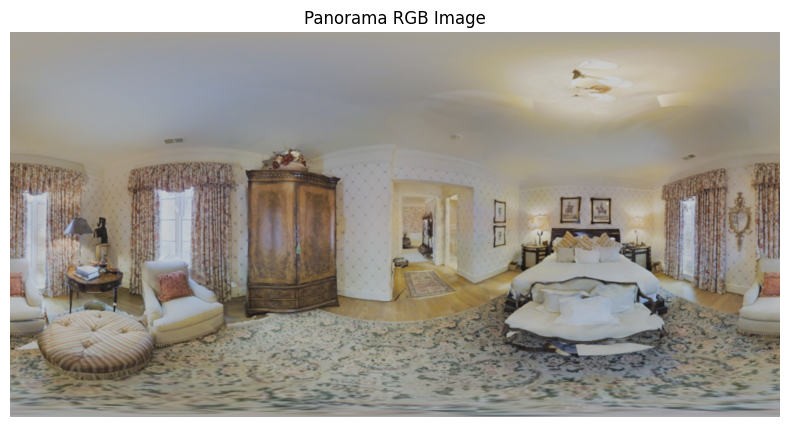

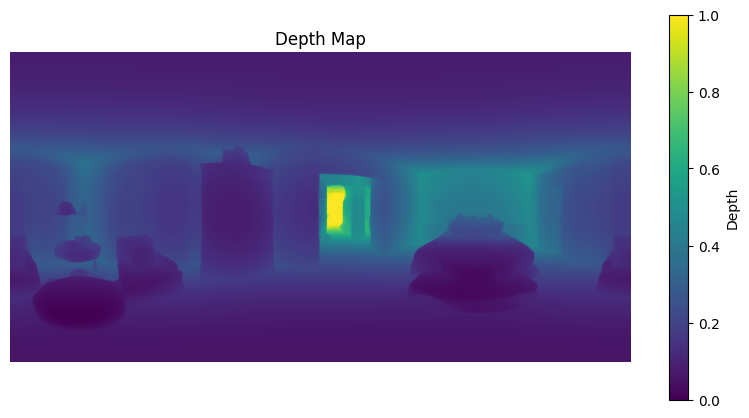

In [4]:
def visualize_rgb(panorama_tensor):
    # 텐서를 NumPy 배열로 변환
    panorama_np = panorama_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    plt.figure(figsize=(10, 5))
    plt.imshow(panorama_np)
    plt.axis("off")
    plt.title("Panorama RGB Image")
    plt.show()

def visualize_depth(init_depth):
    # 깊이 맵 정규화
    depth_np = init_depth.cpu().numpy()
    depth_normalized = (depth_np - depth_np.min()) / (depth_np.max() - depth_np.min())
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_normalized, cmap="viridis")
    plt.axis("off")
    plt.title("Depth Map")
    plt.colorbar(label="Depth")
    plt.show()

# 시각화
visualize_rgb(panorama_tensor)
visualize_depth(init_depth)

In [5]:
def save_data(tensor, save_path):
    torch.save(tensor, save_path)
    print(f"Saved Complete: {save_path} ")

# 저장 경로 설정
output_folder = "output/Pano2Room-results"
os.makedirs(output_folder, exist_ok=True)

# 저장 경로
rgb_save_path = os.path.join(output_folder, "panorama_tensor.pt")
depth_save_path = os.path.join(output_folder, "init_depth.pt")

# 저장
save_data(panorama_tensor, rgb_save_path)
save_data(init_depth, depth_save_path)

Saved Complete: output/Pano2Room-results/panorama_tensor.pt 
Saved Complete: output/Pano2Room-results/init_depth.pt 


# Retrieve the depth edge mask $M_D$

In [6]:
def visualize_mask(depth_edge_inpaint_mask):
    depth_edge_inpaint_mask_np = depth_edge_inpaint_mask.cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_edge_inpaint_mask_np,  cmap="gray")
    plt.axis("off")
    plt.title("Depth Edge Map $M_D$")
    plt.show()

In [7]:
def find_depth_edge(depth, dilate_iter=0):
    gray = (depth/depth.max() * 255).astype(np.uint8)
    edges = cv2.Canny(gray, 60, 150)
    if dilate_iter > 0:
        kernel = np.ones((3, 3), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=dilate_iter)
    return edges   

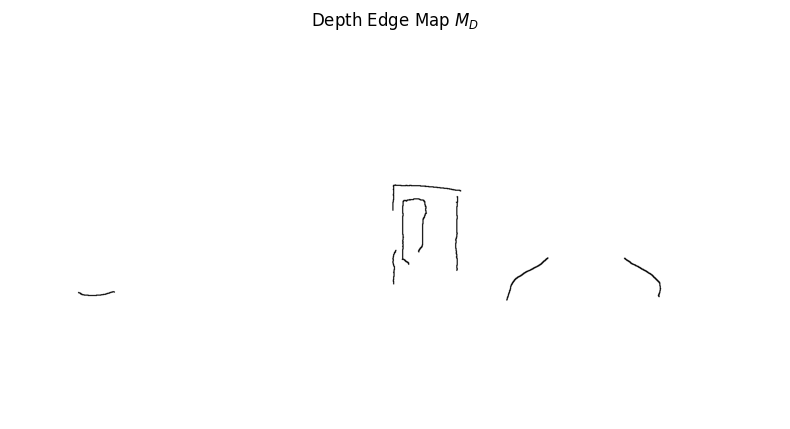

In [8]:
depth_edge = find_depth_edge(init_depth.cpu().detach().numpy(), dilate_iter=1)
depth_edge_pil = Image.fromarray(depth_edge)
depth_pil = Image.fromarray(visualize_depth_numpy(init_depth.cpu().detach().numpy())[0].astype(np.uint8))
save_rgbd(depth_pil, depth_edge_pil, f'depth_edge', 0, output_folder)

# Edge 에 해당하는 부분: False (검정색)
# Edge 외 모든 부분 : True (하얀색)
depth_edge_inpaint_mask = ~(torch.from_numpy(depth_edge).cuda().bool())
visualize_mask(depth_edge_inpaint_mask)

# Convert Panorama 2D space to 3D space
- Fisrt,
- Second, 

In [9]:
def rgb_to_mesh(rgb,
                depth,
                world_to_cam=None, 
                mask=None, 
                pix_to_face=None, 
                using_distance_map=False):
    
    predicted_depth = depth.cuda()
    rgb = rgb.squeeze(0).cuda()
    if world_to_cam is None:
        world_to_cam = torch.eye(4, dtype=torch.float32)
    world_to_cam = world_to_cam.cuda()
    if pix_to_face is not None:
        pix_to_face = pix_to_face
    if mask is None:
        inpaint_mask = torch.ones_like(predicted_depth)
    else:
        inpaint_mask = mask
    if inpaint_mask.sum() == 0:
         return

    # Initialize Meshs {V, C, F}
    fov = 90
    V = torch.empty((3, 0), device=device, requires_grad=False)
    F = torch.empty((3, 0), device=device, dtype=torch.long, requires_grad=False)
    C = torch.empty((3, 0), device=device, requires_grad=False)

    vertices, faces, colors = features_to_world_space_mesh(
        colors=rgb,
        depth=predicted_depth,
        fov_in_degrees=fov,
        world_to_cam=world_to_cam,
        mask=inpaint_mask,
        pix_to_face=pix_to_face,
        faces=F,
        vertices=V,
        using_distance_map=using_distance_map,
        edge_threshold=0.05
    )
    faces += V.shape[1] 

    V = torch.cat([V, vertices], dim=1)
    C = torch.cat([C, colors], dim=1)
    F = torch.cat([F, faces], dim=1)

    return V, F, C

def pano_distance_to_mesh(pano_rgb, 
                          pano_distance,
                          depth_edge_inpaint_mask,
                          pose=None):
    
    V, F, C = rgb_to_mesh(pano_rgb, 
                          pano_distance, 
                          mask=depth_edge_inpaint_mask, 
                          using_distance_map=True, 
                          world_to_cam=pose)
    
    vertices_np = V.permute(1, 0).cpu().numpy()
    faces_np = F.T.cpu().numpy()

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices_np)
    mesh.triangles = o3d.utility.Vector3iVector(faces_np)

    colors_np = C.permute(1, 0).cpu().numpy()
    mesh.vertex_colors = o3d.utility.Vector3dVector(colors_np)
        
    return mesh

In [10]:
mesh = pano_distance_to_mesh(panorama_tensor, init_depth, depth_edge_inpaint_mask)
print(mesh)
file_path = "/home/Pano2Room/output/Pano2Room-results/mesh.ply"
o3d.io.write_triangle_mesh(file_path, mesh)
print(f"Mesh 저장 완료: {file_path}")

TriangleMesh with 2087815 points and 4157800 triangles.
Mesh 저장 완료: /home/Pano2Room/output/Pano2Room-results/mesh.ply
